# Intro

Here we use only **1** cell-type as perturbed, NOT all cell-types.
This is done when we generate the pseudobulks by sampling from either perturbed or non-perturbed cells within each sample.
This is denoted in the parameter `res_name`, it can be "all-kang", "mono-kang", "b-kang", "cd4Naive-kang", or "none-kang" and `idx_skip`.


This notebook takes the QC-ed the Kang et.al. data and generates pseudobulks.
The data was retreived using  the SeuratData package in R and then translated into an AnnData object to be read into python,
Notebook for SeuratData analysis of Kang data (names ifnb in SeuratData): https://satijalab.org/seurat/articles/integration_introduction.html
Seurat Disk was used for conversion between h5Seurat and AnnData: https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html

Kang data is originally from here: 
Kang, Hyun Min, et al. "Multiplexed droplet single-cell RNA-sequencing using natural genetic variation." Nature biotechnology 36.1 (2018): 89-94.


Data format requirements for single-cell data:
- processed data is not scaled
- cells are filtered such that low-quality cells are removed (for example: filter out cells with less than 200 genes and genes expressed in less than 3 cells, and > 5% MT reads)
- data is saved as an AnnData object and you have sample IDs, gene IDs, and cell-type labels
- In the end we will process the data such that we have the following features in the AnnData object that we will use to generate pseudobulks:
  - the observations have columns named: "sample_id", "stim", "isTraining"
  - sample_id: unique IDs for the samples
  - stim: is "STIM" or "CTRL", denotes if the sample is "stimulated" or "control"
  - isTraining: 'Train' or 'Test',  denotes if you can use the sample during training or not. In real use cases, all data will be "Train". To show validation of our experiment, we have access to "Test" data as well.
  


Pseudobulk features:
- we typically generate 1000 pseudobulks per sample with random proportions
- we generate 100 pseudobulks per sample, per cell type, where the cell-type of interest is >90% of the cell-type
- we typically sample 5000 cells for each pseudobulk





# Imports

In [1]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi

from buddi.preprocessing import sc_preprocess


# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/

In [2]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)

<module 'buddi.preprocessing.sc_preprocess' from '/Users/davidnat/Documents/projects/greenelab/buddi/buddi/preprocessing/sc_preprocess.py'>

# Parameters

In [3]:
# parameters

aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_sciplex_data/"
cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_sciplex/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/sciplex/"




#####################
### set the study ###
#####################

res_name = "all-sciplex"
in_name = "sciplex_processed"
processed_sc_file = f"{data_path}/{in_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [4]:
# read in the data

adata = sc.read_h5ad(processed_sc_file)

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



In [5]:
# format metadata


def get_stim_id(in_str):
    out_str = "STIM"
    if in_str == "control":
        out_str = "CTRL"
           
    return(out_str)


adata.obs['CellType'] = adata.obs['cell_line'].tolist()
adata.obs['scpred_CellType'] = adata.obs['cell_line'].tolist()
adata.obs['sample_id'] = "samp1"
adata.obs['stim'] = [get_stim_id(str(x)) for x in adata.obs['perturbation'].tolist()]

adata.var['gene_ids'] = adata.var.gene_short_name.tolist()
adata.var.index = adata.var['gene_ids']

# remove genes that are duplicated
a = (adata.var['gene_ids'].value_counts() == 1)
a = a[a].keys().to_list()
unique_genes = np.unique(a)

adata = adata[:, adata.var['gene_ids'].isin(unique_genes)]

# make the common name the index
adata.var.index = adata.var['gene_ids']


In [6]:
adata.obs

,cell,Size_Factor,n.umi,hash_umis_W,pval_W,qval_W,top_to_second_best_ratio_W,top_oligo_W,hash_umis_P,pval_P,...,dose_value,dose_unit,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CellType,scpred_CellType,sample_id,stim
cell,,,,,,,,,,,,,,,,,,,,,
A01_E09_RT_BC_101_Lig_BC_109,A01_E09_RT_BC_101_Lig_BC_109,0.516561,695.0,93.0,0.0,0.0,27.803759,plate6_G5,117.0,0.000000e+00,...,0.0,nM,421,695.0,0.0,0.0,A549,A549,samp1,CTRL
A01_E09_RT_BC_119_Lig_BC_51,A01_E09_RT_BC_119_Lig_BC_51,0.596832,804.0,154.0,0.0,0.0,43.083832,plate5_C9,99.0,0.000000e+00,...,1000.0,nM,564,803.0,0.0,0.0,A549,A549,samp1,STIM
A01_E09_RT_BC_119_Lig_BC_60,A01_E09_RT_BC_119_Lig_BC_60,0.950620,1279.0,125.0,0.0,0.0,56.936405,plate9_E4,143.0,0.000000e+00,...,1000.0,nM,834,1279.0,0.0,0.0,A549,A549,samp1,STIM
A01_E09_RT_BC_125_Lig_BC_370,A01_E09_RT_BC_125_Lig_BC_370,3.116459,4195.0,261.0,0.0,0.0,92.747985,plate6_G5,354.0,0.000000e+00,...,0.0,nM,1645,4193.0,0.0,0.0,A549,A549,samp1,CTRL
A01_E09_RT_BC_128_Lig_BC_154,A01_E09_RT_BC_128_Lig_BC_154,2.437126,3281.0,150.0,0.0,0.0,135.299254,plate7_H2,74.0,0.000000e+00,...,1000.0,nM,1654,3279.0,0.0,0.0,A549,A549,samp1,STIM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H12_F10_RT_BC_66_Lig_BC_183,H12_F10_RT_BC_66_Lig_BC_183,0.279914,709.0,59.0,0.0,0.0,5.197775,plate5_G11,102.0,2.399244e-109,...,0.0,nM,421,708.0,0.0,0.0,MCF7,MCF7,samp1,CTRL
H12_F10_RT_BC_68_Lig_BC_66,H12_F10_RT_BC_68_Lig_BC_66,1.545458,3910.0,263.0,0.0,0.0,47.443216,plate8_H8,247.0,0.000000e+00,...,10000.0,nM,1890,3909.0,0.0,0.0,MCF7,MCF7,samp1,STIM
H12_F10_RT_BC_81_Lig_BC_137,H12_F10_RT_BC_81_Lig_BC_137,0.294542,747.0,70.0,0.0,0.0,27.489253,plate9_D4,60.0,4.133161e-215,...,0.0,nM,474,745.0,0.0,0.0,MCF7,MCF7,samp1,CTRL


In [7]:
adata.obs.columns

Index(['cell', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W',
       'top_to_second_best_ratio_W', 'top_oligo_W', 'hash_umis_P', 'pval_P',
       'qval_P', 'top_to_second_best_ratio_P', 'top_oligo_P', 'rt_well',
       'lig_well', 'pcr_well', 'pcr_plate', 'culture_plate', 'rt_plate',
       'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate',
       'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern',
       'dose_character', 'dose', 'treatment', 'pathway_level_1',
       'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose',
       'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score',
       'proliferation_index', 'UMAP_1', 'UMAP_2', 'Cluster',
       'louvain_component', 'batch', 'perturbation', 'cell_line', 'dose_value',
       'dose_unit', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'CellType', 'scpred_CellType', 'sample_id', 'stim'],
      dtype='object')

In [8]:
adata.obs.rt_plate.value_counts()

2.0    7220
4.0    7030
3.0    6661
1.0    6236
Name: rt_plate, dtype: int64

### Preprocess

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


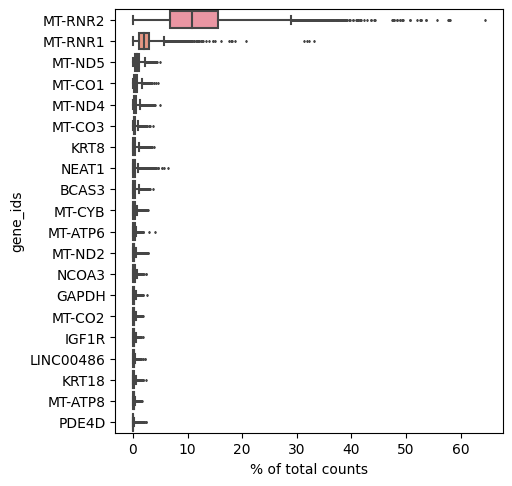

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [10]:
# check we don't have any weird cell types
adata.obs["scpred_CellType"].value_counts()


MCF7    13575
K562     6790
A549     6782
Name: scpred_CellType, dtype: int64

In [11]:
# write out data for BP and cibersort
dense_matrix = adata.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
dense_df.insert(loc=0, column='scpred_CellType', value=adata.obs["scpred_CellType"].to_list())


pickle.dump( dense_df, open( sc_profile_path, "wb" ) )


In [12]:
dense_matrix.shape

(27147, 30517)

# Plot Data

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


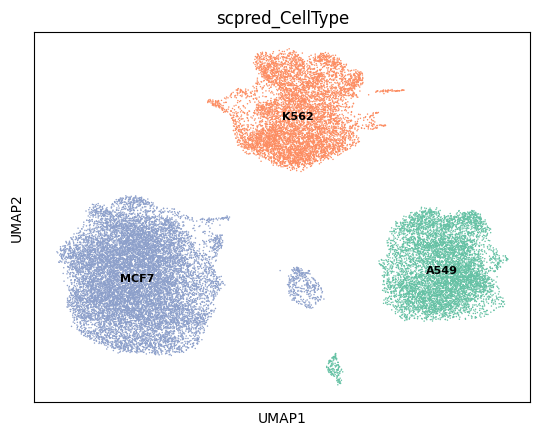

In [13]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

In [14]:
adata.obs

,cell,Size_Factor,n.umi,hash_umis_W,pval_W,qval_W,top_to_second_best_ratio_W,top_oligo_W,hash_umis_P,pval_P,...,dose_value,dose_unit,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CellType,scpred_CellType,sample_id,stim
cell,,,,,,,,,,,,,,,,,,,,,
A01_E09_RT_BC_101_Lig_BC_109,A01_E09_RT_BC_101_Lig_BC_109,0.516561,695.0,93.0,0.0,0.0,27.803759,plate6_G5,117.0,0.000000e+00,...,0.0,nM,421,695.0,0.0,0.0,A549,A549,samp1,CTRL
A01_E09_RT_BC_119_Lig_BC_51,A01_E09_RT_BC_119_Lig_BC_51,0.596832,804.0,154.0,0.0,0.0,43.083832,plate5_C9,99.0,0.000000e+00,...,1000.0,nM,564,803.0,0.0,0.0,A549,A549,samp1,STIM
A01_E09_RT_BC_119_Lig_BC_60,A01_E09_RT_BC_119_Lig_BC_60,0.950620,1279.0,125.0,0.0,0.0,56.936405,plate9_E4,143.0,0.000000e+00,...,1000.0,nM,834,1279.0,0.0,0.0,A549,A549,samp1,STIM
A01_E09_RT_BC_125_Lig_BC_370,A01_E09_RT_BC_125_Lig_BC_370,3.116459,4195.0,261.0,0.0,0.0,92.747985,plate6_G5,354.0,0.000000e+00,...,0.0,nM,1645,4193.0,0.0,0.0,A549,A549,samp1,CTRL
A01_E09_RT_BC_128_Lig_BC_154,A01_E09_RT_BC_128_Lig_BC_154,2.437126,3281.0,150.0,0.0,0.0,135.299254,plate7_H2,74.0,0.000000e+00,...,1000.0,nM,1654,3279.0,0.0,0.0,A549,A549,samp1,STIM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H12_F10_RT_BC_66_Lig_BC_183,H12_F10_RT_BC_66_Lig_BC_183,0.279914,709.0,59.0,0.0,0.0,5.197775,plate5_G11,102.0,2.399244e-109,...,0.0,nM,421,708.0,0.0,0.0,MCF7,MCF7,samp1,CTRL
H12_F10_RT_BC_68_Lig_BC_66,H12_F10_RT_BC_68_Lig_BC_66,1.545458,3910.0,263.0,0.0,0.0,47.443216,plate8_H8,247.0,0.000000e+00,...,10000.0,nM,1890,3909.0,0.0,0.0,MCF7,MCF7,samp1,STIM
H12_F10_RT_BC_81_Lig_BC_137,H12_F10_RT_BC_81_Lig_BC_137,0.294542,747.0,70.0,0.0,0.0,27.489253,plate9_D4,60.0,4.133161e-215,...,0.0,nM,474,745.0,0.0,0.0,MCF7,MCF7,samp1,CTRL


In [15]:
adata.obs["scpred_CellType"].unique()

['A549', 'K562', 'MCF7']
Categories (3, object): ['A549', 'K562', 'MCF7']

In [16]:
# generate cell-type specific split
adata.obs["isTraining"] = "Train"
adata.obs["test_train_key"] = adata.obs["scpred_CellType"].astype(str) + adata.obs["perturbation"].astype(str)

# for each element in the key
# split by 50%
for curr_key in adata.obs["test_train_key"].unique():
  curr_idx = np.where(adata.obs["test_train_key"] == curr_key)[0]
  num_sample = np.floor(len(curr_idx)/2).astype(int)
  test_idx = np.random.choice(curr_idx, num_sample)
  adata.obs["isTraining"][test_idx] = "Test"

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82741/2374458522.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["isTraining"][test_idx] = "Test"


In [17]:
pd.set_option('display.max_rows', 160)

tab = adata.obs.groupby(['test_train_key', 'isTraining']).size()

tab.unstack()

isTraining,Test,Train
test_train_key,,
"A549Fedratinib (SAR302503, TG101348)",263,407
A549Tanespimycin (17-AAG),246,371
A549Trametinib (GSK1120212),244,363
A549Triamcinolone Acetonide,326,495
A549Trichostatin A (TSA),300,480
A549control,1284,2003
"K562Fedratinib (SAR302503, TG101348)",230,352
K562Tanespimycin (17-AAG),243,356
K562Trametinib (GSK1120212),235,361


In [18]:
tab = adata.obs.groupby(['isTraining', 'sample_id']).size()

tab.unstack()

sample_id,samp1
isTraining,
Test,10730
Train,16417


In [19]:
tab = adata.obs.groupby(['isTraining', 'stim']).size()

tab.unstack()

stim,CTRL,STIM
isTraining,,
Test,5114,5616
Train,7890,8527


### Generate proportions matrix + pseudobulk

In [20]:
stim_idx = np.where(np.logical_and(adata.obs.stim == "STIM", adata.obs.isTraining == "Train"))[0]
tab = adata.obs.iloc[stim_idx].groupby(['perturbation', 'scpred_CellType']).size()
tab.unstack()

scpred_CellType,A549,K562,MCF7
perturbation,,,
"Fedratinib (SAR302503, TG101348)",407,352,955
Tanespimycin (17-AAG),371,356,592
Trametinib (GSK1120212),363,361,768
Triamcinolone Acetonide,495,591,1054
Trichostatin A (TSA),480,414,968
control,0,0,0


In [21]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

# metadata
stim_order = ['STIM', 'CTRL']
train_order = ['Train', 'Test']

curr_samp = "samp1"

# now generate all the proportions
total_meta_df = pd.DataFrame(columns = ["sample_id", "stim", "isTraining", "perturbation"])

# no cell noise 
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = adata.obs.scpred_CellType.unique()

# simulate different number of cells
num_cells = 50
idx = 0
for curr_drug in adata.obs["perturbation"].unique():
  if curr_drug == "control":
    continue

  drug_idx = np.where((adata.obs["perturbation"] == curr_drug) | (adata.obs["perturbation"] == "control"))

  adata_drug = adata[drug_idx]

  for curr_cell_type in adata_drug.obs["scpred_CellType"].unique():

    # in order to make a single cell typy perturbed
    # we will only take the STIM of one type and all other cell-types in "stim" will be from CTRL
    idx_skip = np.where(adata_drug.obs["scpred_CellType"].unique() == curr_cell_type)[0]
    idx_keep_cell = np.where(adata_drug.obs["scpred_CellType"].unique() != curr_cell_type)[0]
    keep_cell_types = adata_drug.obs["scpred_CellType"].unique()[idx_keep_cell]
    stim_cell_type = adata_drug.obs["scpred_CellType"].unique()[idx_skip] # cd14 mono OR b OR cd4NaiveT

    stim_fake = np.logical_and(adata_drug.obs.scpred_CellType.isin(keep_cell_types), adata_drug.obs.stim == "CTRL" )
    stim_real = np.logical_and(adata_drug.obs.scpred_CellType.isin(stim_cell_type), adata_drug.obs.stim == "STIM" )
    stim_ternary = np.logical_or(stim_fake, stim_real)

    adata_drug.obs[stim_ternary].scpred_CellType.value_counts()

    # for all other samples
    for curr_stim in stim_order:

      sample_noise = None ## when using training data -- this generates the sample_noise
      for curr_train in train_order:

        print(f"{res_name} {curr_cell_type} {curr_drug} {curr_stim} {curr_train}")

        ########################################################
        ### GET CELLS TO SAMPLE FROM
        ########################################################
        # subset adata_drug to get the correct cells to sample from
        subsamp_subset_idx = adata_drug.obs.isTraining == curr_train
        if curr_stim == "STIM":
          subsamp_subset_idx = np.logical_and(subsamp_subset_idx, stim_ternary)
        else:
          subsamp_subset_idx = np.logical_and(subsamp_subset_idx, adata_drug.obs.stim == "CTRL")
        
        sampling_adata_drug = adata_drug[subsamp_subset_idx]



        ########################################################
        ### MAKE PSEUDOBULKS
        ########################################################
        # now get the pseudobulks

        
        prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(sampling_adata_drug, 
                                                                                num_samples=1000, 
                                                                                num_cells=num_cells,
                                                                                use_true_prop=False,
                                                                                cell_noise=cell_noise,
                                                                                useSampleNoise=False)

        # number of random pseudobulks
        num_rand_pseudo = pseudobulks_df.shape[0] 
        cell_prop_type = ["random"]*num_rand_pseudo 

        if curr_train == "Test":
          # also get the cell type specific pseudobulks

          # get the single cell type proportions
          print("get_single_celltype_prop_matrix")
          ct_prop_df = sc_preprocess.get_single_celltype_prop_matrix(num_samp=100, # 100
                                                                      cell_order=cell_order)

          # now get the cell-type specific pseudobulks
          print("use_prop_make_sum")
          prop_df_sc, pseudobulks_df_sc, _ = sc_preprocess.use_prop_make_sum(sampling_adata_drug,  
                                                                              num_cells=num_cells, 
                                                                              props_vec=ct_prop_df, 
                                                                              cell_noise=cell_noise,
                                                                              sample_noise=None,
                                                                              useSampleNoise=False)

          # number of random pseudobulks
          num_ct_pseudo = pseudobulks_df_sc.shape[0] 

          # put them together
          print("concat")        
          prop_df = pd.concat([prop_df,prop_df_sc])
          pseudobulks_df = pd.concat([pseudobulks_df, pseudobulks_df_sc])

          cell_prop_type = ["random"]*num_rand_pseudo+["cell_type_specific"]*num_ct_pseudo 



        # make the proportions instead of cell counts
        prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)


        # make the metadata
        num_samps = pseudobulks_df.shape[0] 
        samp_type = ["bulk"]*num_samps
        
        metadata_df = pd.DataFrame(data = {"sample_id":[curr_samp]*num_samps, 
                                          "stim":[curr_stim]*num_samps,
                                          "isTraining":[curr_train]*num_samps,
                                          "cell_prop_type":cell_prop_type,
                                          "samp_type":samp_type,
                                          "perturbation":curr_drug,
                                          "cell_type_perturbed":curr_cell_type})



        pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_{curr_drug}_{curr_cell_type}_{curr_stim}_{curr_train}_pseudo_splits.pkl")
        prop_file = os.path.join(aug_data_path, f"{res_name}_{curr_drug}_{curr_cell_type}_{curr_stim}_{curr_train}_prop_splits.pkl")
        meta_file = os.path.join(aug_data_path, f"{res_name}_{curr_drug}_{curr_cell_type}_{curr_stim}_{curr_train}_meta_splits.pkl")

        print("write")        
        pseudobulk_path = Path(pseudobulk_file)
        prop_path = Path(prop_file)
        meta_path = Path(meta_file)

        pickle.dump( prop_df, open( prop_path, "wb" ) )
        pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )
        pickle.dump( metadata_df, open( meta_path, "wb" ) )





all-sciplex A549 Fedratinib (SAR302503, TG101348) STIM Train
0
100
200
300
400
500
600
700
800
900
1000
write
all-sciplex A549 Fedratinib (SAR302503, TG101348) STIM Test
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
concat
write
all-sciplex A549 Fedratinib (SAR302503, TG101348) CTRL Train
0
100
200
300
400
500
600
700
800
900
1000
write
all-sciplex A549 Fedratinib (SAR302503, TG101348) CTRL Test
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
concat
write
all-sciplex K562 Fedratinib (SAR302503, TG101348) STIM Train
0
100
200
300
400
500
600
700
800
900
1000
write
all-sciplex K562 Fedratinib (SAR302503, TG101348) STIM Test
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
concat
write
all-sciplex K562 Fedratinib (SAR302503, TG101348) CTRL Train
0
100
200
300
400
500
600
700
800
900
1000
write
all-sciplex K562 Fedratinib (SAR